<a href="https://colab.research.google.com/github/AndyMDH/pneumonia_detection_cnn/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCK506  End of Module: Pneumonia Detection through Convolutional Neural Network (CNN)



## Table of Contents
1. [Introduction](#section-1)
2. [Exploratory Data Analysis](#section-2)
3. [Data Preprocessing and Augmentation](#section-3)
4. [CNN Architecture Development](#section-4)
5. [Model Evaluation](#section-5)
6. [Summary & Retrospective](#section-6)
7. [References](#section-7)

---
## Introduction

Pneumonia poses a severe threat to human health, being a potentially life-threatening infectious illness that typically affects one or both lungs. It is frequently triggered by bacteria, notably Streptococcus pneumoniae. According to the World Health Organization (WHO), pneumonia is responsible for one in three deaths in India (Varshni et al., 2019). Medical practitioners often rely on X-ray scans to diagnose pneumonia, distinguishing between bacterial and viral types.

This Jupyter notebook delves into the realm of automated pneumonia detection using Convolutional Neural Networks (CNNs). Specifically, it addresses the task of training a CNN model to differentiate between healthy lung scans and those afflicted with pneumonia. The dataset utilised for this endeavor is sourced from the Kaggle competition repository, offering a collection of chest X-ray images categorised as pneumonia-positive and normal.


**This task involves, but is not limited to:**

a. CNN Model Development:

- Write code to train a CNN model using the provided dataset.
- Objective: Achieve optimal performance in distinguishing between healthy and pneumonia-infected lung images.

    - **Key considerations:**
      - Define CNN architecture, including convolution-pooling blocks.
      - Fine-tune parameters like strides, padding, and activation functions for accuracy.
      - Implement strategies to prevent overfitting and ensure model generalization.

b. Training and Evaluation:

- Train the CNN model using the provided training dataset.
Fine-tune hyperparameters using validation data to enhance performance.
- Evaluate the model's accuracy using a separate test dataset to validate pneumonia detection in chest X-ray images.

This Jupyter Notebook was collaboratively prepared by:

- Minh-Dat Andy Ho Huu
- Santiago Fernandez Blanco
- Ismael Saumtally
- Chi Chuen Wan
- Chui Yi Wong

### Import Dependencies

In [1]:
!pip install keras-tuner

In [2]:
# Standard library imports
import logging
import os
import random
import warnings
from zipfile import ZipFile

# Related third-party imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                                     Dropout, Flatten, MaxPooling2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Local application/library specific imports
from google.colab import drive

# Warnings configuration
warnings.filterwarnings('ignore')

<ipython-input-2-160545ef0c8e>:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. If you don't have a GPU, set this to False.

In [3]:
USE_CUDA = True

In [4]:
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

### Download Pneumonia Dataset

The Corpus can be downloaded here: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download)

In [5]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

**Load Dataset into DataFrame from Google Drive**

In [6]:
# Mount Google Drive
drive.mount('/content/drive')

# Defining dataset directory
DATASET_DIR = "/content/drive/MyDrive/Liverpool/CSCK506 Deep Learning/End of Module/archive/chest_xray"
train_dir = DATASET_DIR + "/train"
val_dir = DATASET_DIR + "/val"
test_dir = DATASET_DIR + "/test"

if os.path.exists(train_dir) and os.path.exists(val_dir) and os.path.exists(test_dir):
    print("Dataset directories exist.")
else:
    print("One or more dataset directories are not found. Please recheck the file locations.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directories exist.


##### **Alternatively**, if you're running this notebook from your local machine, you can open, uncomment, and run the code block below to download and unzip the x-ray files from Kaggle.

In [7]:
# def download_file(url, destination):
#     try:
#         urllib.request.urlretrieve(url, destination)
#         logger.info(f'Downloaded file from {url} to {destination}')
#     except Exception as e:
#         logger.error(f'Error downloading file: {e}')

# def extract_zip(zip_path, extract_path):
#     try:
#         with ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(extract_path)
#         logger.info(f'Extracted {zip_path} to {extract_path}')
#     except Exception as e:
#         logger.error(f'Error extracting zip file: {e}')

# def create_directory(directory):
#     if not os.path.exists(directory):
#         os.makedirs(directory)
#         logger.info(f'Created directory: {directory}')

# DATASET_NAME = 'chest_x_ray'
# DATASET_URL = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download'
# DATASET_DIR = os.path.join(DATASET_NAME)
# DATASET_ZIP = os.path.join(DATASET_DIR, 'archive.zip')

# # Check if dataset directory already exists
# if os.path.exists(DATASET_DIR):
#     print(f'{DATASET_NAME} already exists')
# else:
#     if os.path.exists(DATASET_ZIP):
#         create_directory(DATASET_DIR)
#         extract_zip(DATASET_ZIP, CORPUS_DIR)
#         os.remove(DATASET_ZIP)
#         print(f'{DATASET_URL_NAME} extracted')
#     else:
#         print(f'To obtain the "{DATASET_NAME}" dataset, please follow these steps:')
#         print(f'1. Manually download the WikiQA dataset from: {DATASET_URL}')
#         print(f'2. Place the downloaded "archive.zip" file in the "{DATASET_DIR}" folder.')
#         print(f'3. Rerun this script after placing the corpus in the correct location.')


---
## Exploratory Data Analysis

Processing Train dataset...
Image counts for Train: {'NORMAL': 1341, 'PNEUMONIA': 3875}


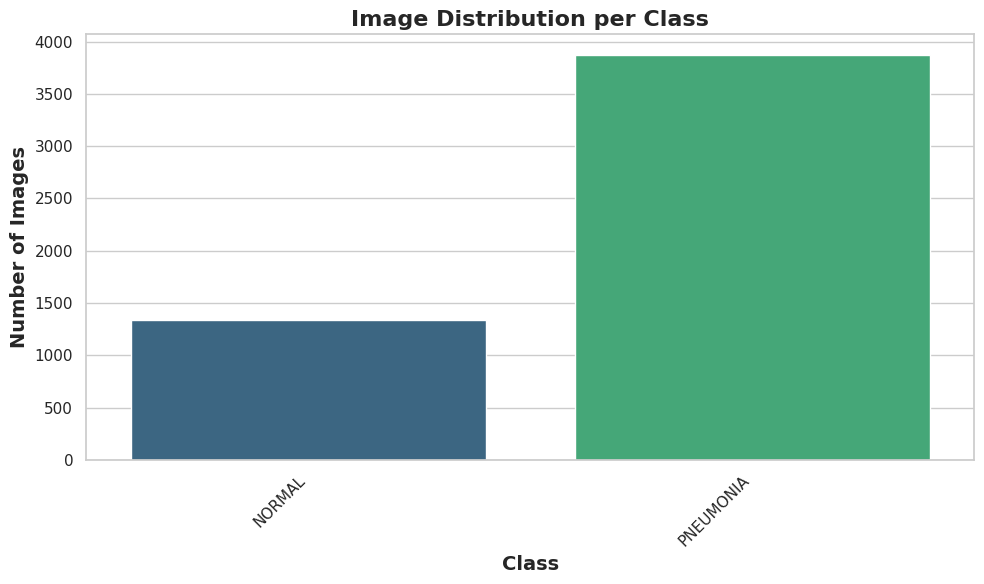

Processing Validation dataset...
Image counts for Validation: {'PNEUMONIA': 8, 'NORMAL': 8}


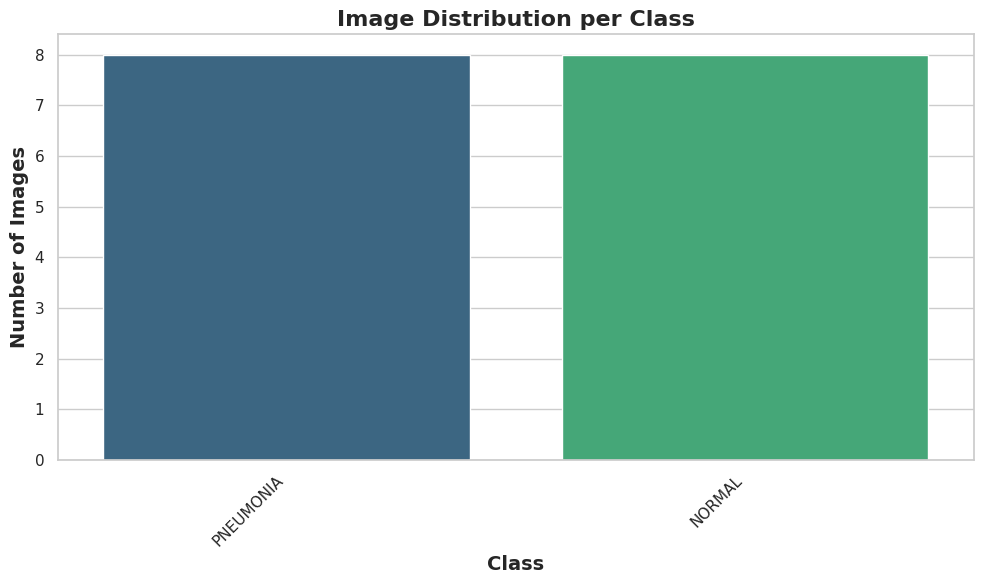

Processing Test dataset...
Image counts for Test: {'PNEUMONIA': 390, 'NORMAL': 234}


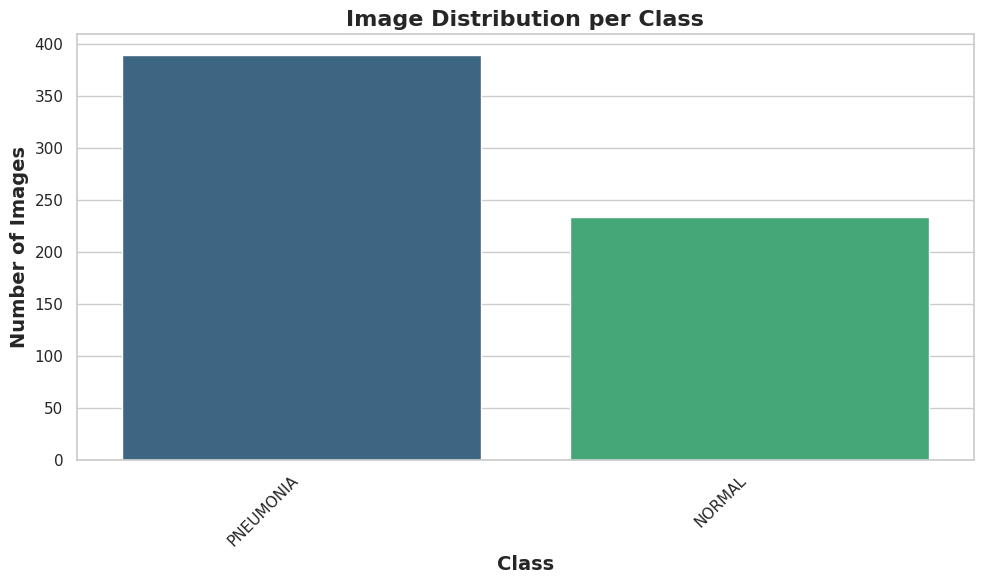

In [8]:
def count_images(dir_path):
    """
    Counts the number of images in each subdirectory for the given directory path.
    """
    counts = {}
    for class_name in os.listdir(dir_path):
        class_dir = os.path.join(dir_path, class_name)
        if os.path.isdir(class_dir):
            counts[class_name] = len(os.listdir(class_dir))
    return counts

def visualize_counts(counts_dict):
    """
    Visualizes the image counts using a bar chart.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    classes = list(counts_dict.keys())
    counts = list(counts_dict.values())
    sns.barplot(x=classes, y=counts, palette="viridis")
    plt.xlabel('Class', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=14, fontweight='bold')
    plt.title('Image Distribution per Class', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

DATASET_DIRS = {
    "Train": train_dir,
    "Validation": val_dir,
    "Test": test_dir
}

for dataset_name, dir_path in DATASET_DIRS.items():
    print(f"Processing {dataset_name} dataset...")
    counts = count_images(dir_path)
    print(f"Image counts for {dataset_name}: {counts}")
    visualize_counts(counts)

In [9]:
def display_sample_images(dir, class_, num_samples=3):
    class_dir = os.path.join(dir, class_)
    sample_images = random.sample(os.listdir(class_dir), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 20))
    for ax, image in zip(axes, sample_images):
        img_path = os.path.join(class_dir, image)
        img = mpimg.imread(img_path)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

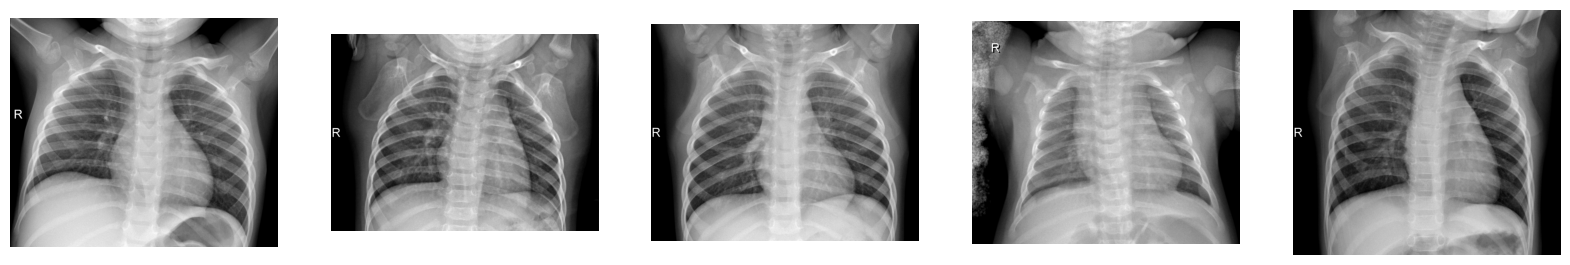

In [10]:
display_sample_images(train_dir, 'NORMAL', 5)

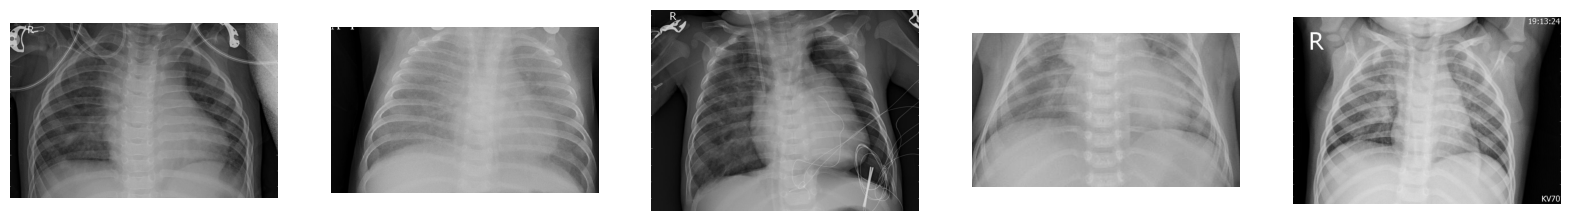

In [11]:
display_sample_images(train_dir, 'PNEUMONIA', 5)

---
## Data Preprocessing & Augmentation


In [12]:
# Define constants
ROTATION_RANGE = 20
WIDTH_SHIFT_RANGE = 0.1
HEIGHT_SHIFT_RANGE = 0.1
HORIZONTAL_FLIP = True
FILL_MODE = 'nearest'
TARGET_SIZE = (300, 300)
RESCALE = 1. / 255.
BATCH_SIZE = 32

def create_augmented_data_generator(train_dir):
    """
    Create a data generator for training images with augmentation.

    Args:
        train_dir (str): Path to the directory containing training images.

    Returns:
        DirectoryIterator: Data generator for training images with augmentation.
    """
    train_datagen = ImageDataGenerator(
        rotation_range=ROTATION_RANGE,
        width_shift_range=WIDTH_SHIFT_RANGE,
        height_shift_range=HEIGHT_SHIFT_RANGE,
        horizontal_flip=HORIZONTAL_FLIP,
        fill_mode=FILL_MODE,
        rescale=RESCALE
    )

    train_data_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    return train_data_generator

def create_val_data_generator(val_dir):
    """
    Create a data generator for validation images without augmentation.

    Args:
        val_dir (str): Path to the directory containing validation images.

    Returns:
        DirectoryIterator: Data generator for validation images without augmentation.
    """
    val_datagen = ImageDataGenerator(rescale=RESCALE)

    val_data_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    return val_data_generator

def create_test_data_generator(test_dir):
    """
    Create a data generator for test images without augmentation.

    Args:
        test_dir (str): Path to the directory containing test images.

    Returns:
        DirectoryIterator: Data generator for test images without augmentation.
    """
    test_datagen = ImageDataGenerator(rescale=RESCALE)

    test_data_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    return test_data_generator

In [13]:
# Call the function to create augmented data generator for training set
train_data_generator = create_augmented_data_generator(train_dir)

# Call the function to create data generator for validation set
val_data_generator = create_val_data_generator(val_dir)

# Call the function to create data generator for test set
test_data_generator = create_test_data_generator(test_dir)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


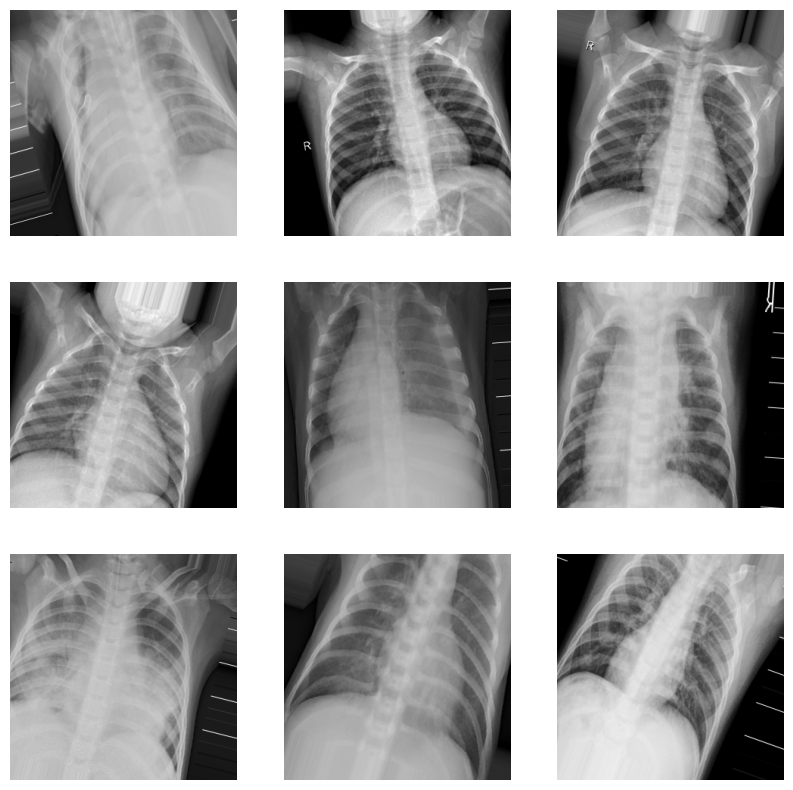

In [14]:
for i, (images, labels) in enumerate(train_data_generator):
    if i == 1:
        break  # We only want to see the first batch
    plt.figure(figsize=(10, 10))
    for j in range(9):  # Display the first 9 images of the batch
        ax = plt.subplot(3, 3, j + 1)
        plt.imshow(images[j])
        plt.axis("off")

---
## CNN Architecture Development

In [15]:
# Dataset Imbalance = Over sampling in Validation to address this

In [16]:
model = tf.keras.models.Sequential([
    # Initialise the input layer with the input shape
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=(2, 2), input_shape=(300, 300,3), name="First_Convolution"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.2, name='Dropout_1'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Middle convolutional layers to extract features
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=(2, 2), name="Second_Convolution"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.2, name='Dropout_2'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Last convolutional layers to extract higher level features
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', strides=(2, 2), name="Third_Convolution"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.3, name='Dropout_3'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

    # Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

Using L2 regularization in conjunction with dropout can indeed be a good strategy for preventing overfitting, especially in deep learning models where there's a high risk of learning too much from the training data at the expense of generalization. L2 regularization works by adding a penalty on the magnitude of the coefficients related to the L2 norm of the weights, encouraging the weights to be small and, in turn, the model to be simpler.

The combination of dropout and L2 regularization can work well because they tackle overfitting from slightly different angles:

Dropout reduces overfitting by randomly omitting a subset of features (by setting a fraction of input units to zero) at each step during training, forcing the model to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.

L2 regularization discourages the weights from reaching large values, which can lead to overfitting by making the model too sensitive to the input data. It does this by adding a component to the loss that is proportional to the square of the magnitude of the weights, effectively penalizing peaky weights and encouraging weight distributions that spread out the importance across more features.

In [17]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, mode='min', verbose=1)
callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_Convolution (Conv2D)  (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 Dropout_1 (Dropout)         (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 Second_Convolution (Conv2D  (None, 38, 38, 64)        1

#### **Model Observations**

In [ ]:
history = model.fit(train_data_generator,
                    epochs=30,
                    validation_data=test_data_generator,
                    callbacks=callbacks)

Epoch 1/30
163/163 [==============================] - 249s 2s/step - loss: 1.0231 - accuracy: 0.8785 - val_loss: 2.9375 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 247s 2s/step - loss: 0.4806 - accuracy: 0.9446 - val_loss: 2.9644 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - 258s 2s/step - loss: 0.3467 - accuracy: 0.9463 - val_loss: 2.6381 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/30
 79/163 [=============>................] - ETA: 2:07 - loss: 0.3036 - accuracy: 0.9383

In [ ]:
def plot_metrics(history, metric='accuracy'):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric], label='Training ' + metric.capitalize(), color='blue', linestyle='-')
    plt.plot(history.history['val_' + metric], label='Validation ' + metric.capitalize(), color='orange', linestyle='--')
    plt.title('Model ' + metric.capitalize())
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metrics(history, metric='accuracy')
plot_metrics(history, metric='loss')

---
## Hyperparameter Tuning

After addressing the immediate model improvements, a chapter on hyperparameter tuning can focus on systematic approaches to finding the best model configuration. Topics to cover could include:

Introduction to Hyperparameter Tuning: Understanding what hyperparameters are and why tuning them is crucial for model performance.
Manual vs. Automated Tuning: The pros and cons of manual tuning versus using automated tools like Grid Search, Random Search, Bayesian Optimization, and others.
Using Keras Tuner: An introduction to Keras Tuner, a library for automated hyperparameter tuning with TensorFlow, including practical examples.
Practical Tips for Tuning: Best practices for conducting hyperparameter tuning, such as how to select which hyperparameters to tune, setting up your tuning domain, and interpreting tuning results.
Advanced Techniques: An overview of more sophisticated tuning strategies, such as multi-fidelity optimization and meta-learning.

In [ ]:
# Suggest to use Keras Tuner

---
## Model Evaluation

- Confusion Matrix
Predicted vs Actual


In [ ]:
# Load the best model saved by ModelCheckpoint callback
model = tf.keras.models.load_model('best_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data_generator)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

In [ ]:
# Generate predictions
predictions = model.predict(test_data_generator)
predicted_labels = np.round(predictions).flatten()

# Get the actual labels
actual_labels = test_data_generator.labels

# Create confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Visualize some test images with their predicted and actual labels
def visualize_predictions(image_batch, actual_labels, predicted_labels, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(image_batch[i])
        plt.title(f"Actual: {['Negative', 'Positive'][actual_labels[i]]}\nPredicted: {['Negative', 'Positive'][int(predicted_labels[i])]}")
        plt.axis("off")

# Get a batch of images and labels from the test data generator
for image_batch, label_batch in test_data_generator:
    # Make sure the generator is not shuffled, to match the predictions
    visualize_predictions(image_batch, label_batch, predicted_labels[:len(image_batch)], num_images=len(image_batch))
    break  # We break here to only process the first batch

---
## Summary & Retrospective

---
## References:

Varshni, D., Thakral, K., Agarwal, L., Nijhawan, R. and Mittal, A. (2019). Pneumonia Detection Using CNN based Feature Extraction. [online] IEEE Xplore. doi:https://doi.org/10.1109/ICECCT.2019.8869364.